In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import utilities
import os
import time

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import random

## Prepare Dataset

**1. Custom Dataloader for x2 scale and /2 scale**

In [2]:
def chunk(indices, size):
    return torch.split(torch.tensor(indices), size)

class MyBatchSampler():
    def __init__(self, a_indices, b_indices, batch_size): 
        self.a_indices = a_indices
        self.b_indices = b_indices
        self.batch_size = batch_size
    
    def __iter__(self):
        random.shuffle(self.a_indices)
        random.shuffle(self.b_indices)
        a_batches  = chunk(self.a_indices, self.batch_size)
        b_batches = chunk(self.b_indices, self.batch_size)
        all_batches = list(a_batches + b_batches)
        all_batches = [batch.tolist() for batch in all_batches]
        random.shuffle(all_batches)
        return iter(all_batches)
    
    def __len__(self):
        return (len(self.a_indices) + len(self.b_indices)) // self.batch_size

**1. load dataset**

In [3]:
train_transform_up = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_transform_dn = transforms.Compose([
    transforms.RandomResizedCrop(size=(16, 16)),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

def get_training_dataloader(train_transform_up,train_transform_dn , batch_size=32, num_workers=0, shuffle=True):
    transform_train_up = train_transform_up
    transform_train_dn = train_transform_dn
    
    cifar10_training_up = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train_up)
    cifar10_training_dn = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train_dn)
    
    cifar10_combined = ConcatDataset((cifar10_training_up, cifar10_training_dn))
    
    a_len = cifar10_training_up.__len__()
    b_len = cifar10_training_dn.__len__()
    ab_len = a_len + cifar10_training_dn.__len__()
    a_indices = list(range(a_len))
    b_indices = list(range(a_len, ab_len))

    batch_sampler = MyBatchSampler(a_indices, b_indices, batch_size)
    
    cifar10_combined = DataLoader(
        cifar10_combined, batch_sampler=batch_sampler)
    
    return cifar10_combined

def get_testing_dataloader(test_transform, batch_size=32, num_workers=0, shuffle=True):
    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader

In [4]:
trainloader = get_training_dataloader(train_transform_up, train_transform_dn)
testloader = get_testing_dataloader(test_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 73387474.40it/s]                               


Files already downloaded and verified
Files already downloaded and verified


**2. View some random images from the training dataset:**

In [5]:
# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

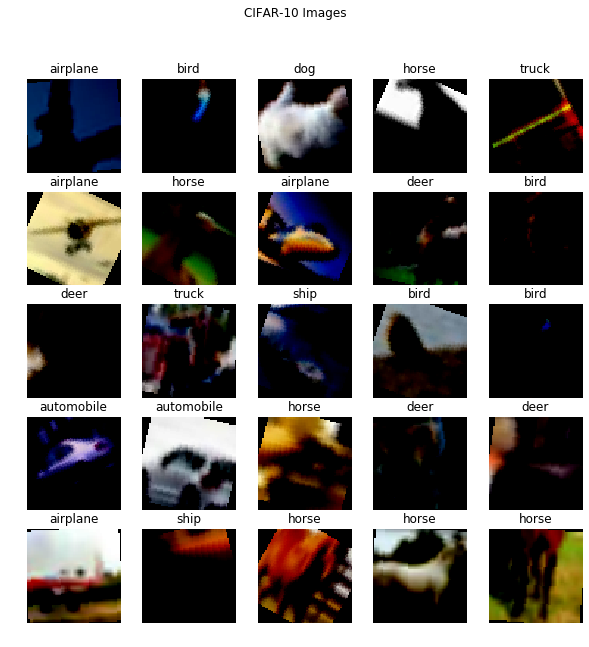

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
    
for batch_idx, (inputs, labels) in enumerate(trainloader):
    for im in range(25):
        image = inputs[im].permute(1, 2, 0)
        i = im // 5
        j = im % 5
        axs[i,j].imshow(image.numpy()) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(classes_dict[int(labels[im].numpy())])
        
    break;

# set suptitle
plt.suptitle('CIFAR-10 Images')
plt.show()

## Build Model

In [7]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channel = 4 * growth_rate

        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        inner_channels = 2 * growth_rate

        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block
    

**Độ sâu của DenseNet được tính theo số convolutional layer và classification layer:**
*    Tính thử độ sâu của DenseNet121:
   - Convolution: +1
   
   - Dense block 1: (1x1 conv + 3x3 conv) x 6 ==> +12
   - Transition 1: +1
   
   - Dense block 2: (1x1 conv + 3x3 conv) x 12 ==> +24
   - Transition 2: +1
   
   - Dense block 3: (1x1 conv + 3x3 conv) x 24 ==> +48
   - Transition 3: +1
   
   - Dense block 4: (1x1 conv + 3x3 conv) x 16 ==> +32
   
   - Classification layer: +1
* ==> Độ sâu của DenseNet121: 1 + 12 + 24 + 1 + 48 + 1 + 32 + 1 = 121


**Vậy DenseNet18 sẽ được set up như sau:**
   - Convolution: +1
   
   - Dense block 1: (1x1 conv + 3x3 conv) x 2 ==> +4
   - Transition 1: +1
   
   - Dense block 2: (1x1 conv + 3x3 conv) x 2 ==> +4
   - Transition 2: +1
   
   - Dense block 3: (1x1 conv + 3x3 conv) x 3 ==> +6
   
   - Classification layer: +1
* ==> Densenet18 = 1 + 4 + 1 + 4 + 1 + 6 + 1 == 18

In [ ]:
def densenet18(activation='relu'):
    return DenseNet(Bottleneck, [2, 2, 3], growth_rate=32)

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

In [15]:
epochs = 15
learning_rate = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**1. Initialize the model:**

In [16]:
model = densenet18()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [18]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

359434


In [21]:
model.eval()

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottle_neck_layer_0): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottle_neck_layer_1): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace)
          (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, m

**2. Training**

In [19]:
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    model.train()

Epoch 1/15.. Time per epoch: 179.6847.. Average time per step: 0.0575.. Train loss: 1.7869.. Train accuracy: 0.3404.. Test loss: 1.5537.. Test accuracy: 0.4286.. 
Epoch 2/15.. Time per epoch: 179.4442.. Average time per step: 0.0574.. Train loss: 3.3846.. Train accuracy: 0.4253.. Test loss: 1.5866.. Test accuracy: 0.4688.. 
Epoch 3/15.. Time per epoch: 179.4877.. Average time per step: 0.0574.. Train loss: 4.8902.. Train accuracy: 0.4595.. Test loss: 1.3207.. Test accuracy: 0.5465.. 
Epoch 4/15.. Time per epoch: 178.7252.. Average time per step: 0.0572.. Train loss: 6.3318.. Train accuracy: 0.4854.. Test loss: 1.1966.. Test accuracy: 0.5820.. 
Epoch 5/15.. Time per epoch: 178.4559.. Average time per step: 0.0571.. Train loss: 7.7222.. Train accuracy: 0.5058.. Test loss: 1.1840.. Test accuracy: 0.5943.. 
Epoch 6/15.. Time per epoch: 178.1684.. Average time per step: 0.0570.. Train loss: 9.0693.. Train accuracy: 0.5203.. Test loss: 1.1850.. Test accuracy: 0.6011.. 
Epoch 7/15.. Time per 

## Inference

In [28]:
def view_classify(img, ps, title):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(classes_dict.values()), size='small');
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


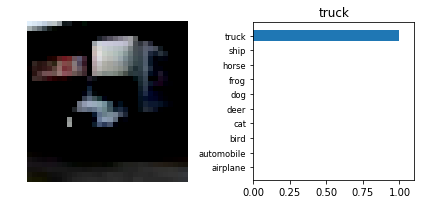

In [36]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;